In [11]:
import pandas
import seaborn as sns
import numpy
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
sns.set_style()
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams.update({'font.size': 18})

In [107]:
split_str = "org.apache.spark.mllib.clustering.LDA logInfo - YY="
def load_running_time(filename, change):
    running_times = dict()
    with open(filename) as f:
        for line in f:
            line=line.strip()
            if split_str not in line:
                continue
            line = line.split(split_str)[1].strip()
            line = line.split("=")
            if not line[1].startswith("SumRunningTime"):
                continue
            iter_count = int(line[0][len("Iter:"):])
            running_time = float(line[1][len("SumRunningTime:"):])
            if change and running_time>16000:
                running_time -= 3000
            running_times[iter_count]=running_time
    return running_times

In [91]:
split_str = "org.apache.spark.mllib.clustering.LDA logInfo - YY="
def load_stack_running_time(filename):
    running_times = dict()
    with open(filename) as f:
        for line in f:
            line=line.strip()
            if split_str not in line:
                continue
            line = line.split(split_str)[1].strip()
            line = line.split("=")
            if not line[1].startswith("Duration"):
                continue
            iter_count = int(line[0][len("Iter:"):])
            running_time = float(line[1][len("Duration:"):])/1000
            running_times[iter_count]=running_time
    for iter_count in sorted(list(running_times)):
        if iter_count==0:
            continue
        last_one = iter_count -1
        while last_one not in running_times:
            last_one -= 1
        running_times[iter_count] = running_times[iter_count]+running_times[last_one]
    return running_times

In [92]:
def load_perplexity(filename):
    perplexities = dict()
    with open(filename) as f:
        for line in f:
            line=line.strip()
            if split_str not in line:
                continue
            line = line.split(split_str)[1].strip()
            line = line.split("=")
            if not line[1].startswith("TestPerplexity"):
                continue
            iter_count = int(line[0][len("Iter:"):])
            perplexity = float(line[1][len("SumRunningTime:"):])
            perplexities[iter_count]=perplexity
    return perplexities

In [93]:
def get_time_and_perplexity(filename, model_name, use_stack, change):
    if not use_stack:
        iter_to_running_times = load_running_time(filename, change)
    else:
        iter_to_running_times = load_stack_running_time(filename)
    iter_to_perplexities = load_perplexity(filename)
    times = []
    perplexities = []
    data = []
    for iter_count in iter_to_perplexities.keys():
        if iter_count not in iter_to_running_times:
            continue
        perplexity = iter_to_perplexities[iter_count]
        t = iter_to_running_times[iter_count]
        data.append([model_name, t, perplexity])
    df = pandas.DataFrame(data=data, columns=["Model", "Time", "Perplexity"])
    return df

In [94]:
df1 = get_time_and_perplexity("/Users/sunxiaofei/Downloads/PM_ModelAverage-clean.log", "ModelAverage", False, False)
df2 = get_time_and_perplexity("/Users/sunxiaofei/Downloads/PM_Online-clean.log", "Online", False, False)
df = df1.append(df2)
df["Log(Time)"] = np.log(df["Time"])
df = df[df["Perplexity"]<12]
df["Perplexity"] = np.exp(df["Perplexity"])
df = df[df["Perplexity"]<21500]
df = df[df["Time"]<36000]
df["8 workers"] = df["Model"]

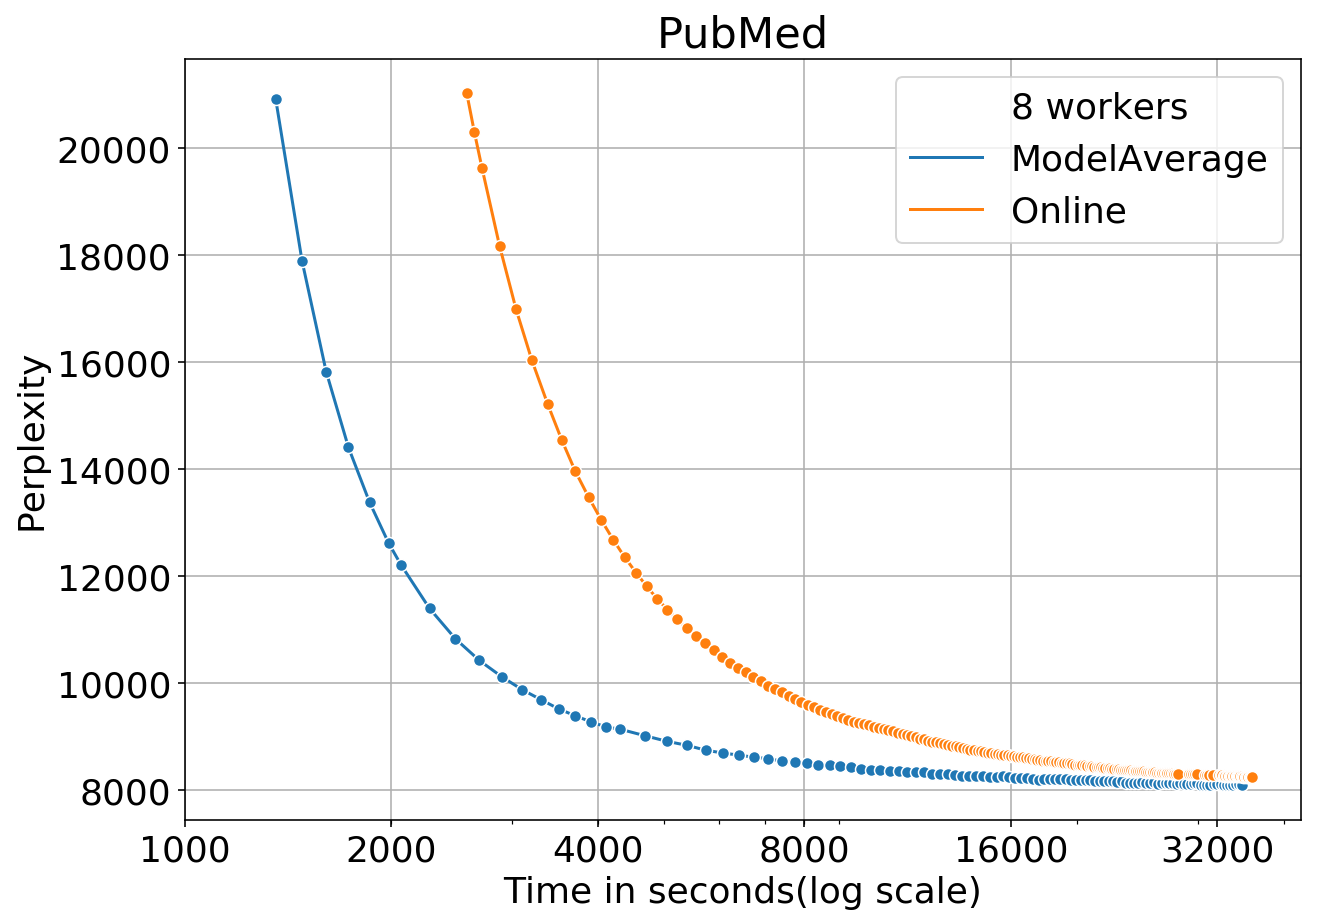

In [95]:
fig, ax = plt.subplots(figsize=(10,7))
sns.lineplot(x="Time", y="Perplexity", hue="8 workers", data=df, markers=True, marker='o')
plt.xscale('log')
plt.xlabel("Time in seconds(log scale)")
plt.title("PubMed")
plt.grid()
ax.set_xticks([1000,2000,4000, 8000, 16000, 32000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.show()

In [112]:
df1 = get_time_and_perplexity("/Users/sunxiaofei/Downloads/NYTimesTwoLine/ModelAverage-NYTimes/ModelAverage", "ModelAverage", True, False)
df2 = get_time_and_perplexity("/Users/sunxiaofei/Downloads/NYTimesTwoLine/Online-NYTimes/Online", "Online", False, True)
df = df1.append(df2)
df["Log(Time)"] = np.log(df["Time"])
df = df[df["Perplexity"]<12]
df["Perplexity"] = np.exp(df["Perplexity"])
df = df[df["Perplexity"]<21500]
df = df[df["Time"]<36000]
df["8 workers"] = df["Model"]

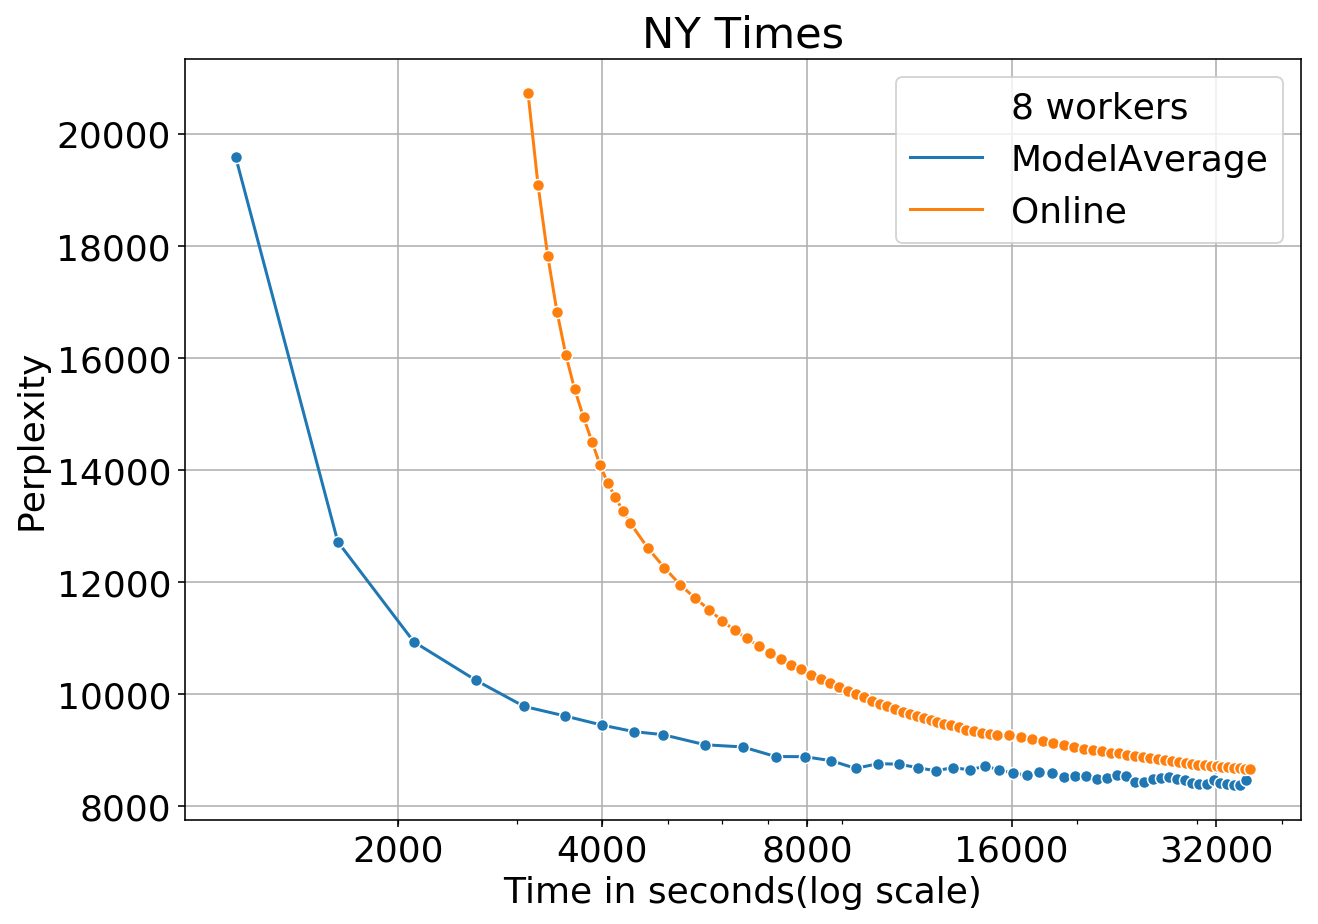

In [113]:
fig, ax = plt.subplots(figsize=(10,7))
sns.lineplot(x="Time", y="Perplexity", hue="8 workers", data=df, markers=True, marker='o')
plt.xscale('log')
plt.xlabel("Time in seconds(log scale)")
plt.title("NY Times")
plt.grid()
ax.set_xticks([2000,4000, 8000, 16000, 32000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# plt.ylim(7000,None)
plt.show()